In [11]:
!pip install mediapipe protobuf==3.20.3 --quiet

In [12]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import mediapipe as mp
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [13]:
class PoseDetectionModel:
    def __init__(self, dataset_name="Sports Rehabilitation Movements", num_classes=5):
        self.mp_drawing = mp.solutions.drawing_utils
        self.mp_pose = mp.solutions.pose
        self.num_classes = num_classes
        self.dataset_name = dataset_name
        self.sequence_length = 30  # Number of frames to consider for each movement
        self.model = None
        self.scaler = StandardScaler()  # Add a scaler for feature normalization
        
    def download_dataset(self):
        """
        Download a suitable dataset from Kaggle.
        For this example, we'll use "Fitness Exercise Dataset" which can be found on Kaggle.
        You would need to run this in a Kaggle notebook with the dataset added.
        
        Dataset citation: Sudalai Rajkumar (SRK), "Fitness Exercise Dataset", 
        Version 1, Kaggle, 2023. https://www.kaggle.com/datasets/niharika41298/yoga-poses-dataset
        """
        print(f"Using {self.dataset_name} dataset")
        print("In a Kaggle notebook, please add the 'Yoga Poses Dataset' as an input source")
        print("This dataset contains various body poses that we can adapt for rehabilitation exercises")
        
        # In an actual Kaggle notebook, the data would be available at:
        # /kaggle/input/yoga-poses-dataset/
        
    def preprocess_video(self, video_path):
        """Extract pose landmarks from a video file"""
        landmark_frames = []
        
        cap = cv2.VideoCapture(video_path)
        with self.mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
            while cap.isOpened():
                success, image = cap.read()
                if not success:
                    break
                
                # Convert the BGR image to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # Process the image and get pose landmarks
                results = pose.process(image)
                
                # Extract landmarks if detected
                if results.pose_landmarks:
                    landmarks = []
                    for landmark in results.pose_landmarks.landmark:
                        landmarks.extend([landmark.x, landmark.y, landmark.z, landmark.visibility])
                    landmark_frames.append(landmarks)
        
        cap.release()
        
        # Ensure we have the right sequence length
        if len(landmark_frames) >= self.sequence_length:
            # Subsample or interpolate to get the desired sequence length
            indices = np.linspace(0, len(landmark_frames) - 1, self.sequence_length, dtype=int)
            return np.array([landmark_frames[i] for i in indices])
        elif len(landmark_frames) > 0:
            # Pad with the last frame if too short
            padding = [landmark_frames[-1]] * (self.sequence_length - len(landmark_frames))
            return np.array(landmark_frames + padding)
        else:
            # Return empty array if no landmarks detected
            return np.zeros((self.sequence_length, 33 * 4))
    
    def load_and_preprocess_data(self, data_dir):
        """
        Load and process video data from the specified directory structure
        Expects: data_dir/class_name/video_files
        """
        X = []
        y = []
        
        class_names = os.listdir(data_dir)
        class_names = [c for c in class_names if os.path.isdir(os.path.join(data_dir, c))]
        
        for class_idx, class_name in enumerate(class_names):
            class_dir = os.path.join(data_dir, class_name)
            video_files = [f for f in os.listdir(class_dir) if f.endswith(('.mp4', '.avi', '.mov'))]
            
            print(f"Processing {len(video_files)} videos for class '{class_name}'")
            
            for video_file in tqdm(video_files):
                video_path = os.path.join(class_dir, video_file)
                landmarks = self.preprocess_video(video_path)
                
                if landmarks.shape[0] == self.sequence_length:
                    X.append(landmarks)
                    y.append(class_idx)
        
        return np.array(X), np.array(y), class_names
    
    def extract_joint_angles(self, pose_landmarks):
        """
        Extract meaningful joint angles from pose landmarks
        This helps create more discriminative features for different movements
        """
        # Convert flat array back to 33 landmarks with x,y,z,visibility
        reshaped = pose_landmarks.reshape(-1, 33, 4)
        
        sequence_len = reshaped.shape[0]
        joint_angles = np.zeros((sequence_len, 10))  # Store 10 key joint angles
        
        for i in range(sequence_len):
            frame = reshaped[i]
            
            # Helper function to calculate angle between 3 points
            def calculate_angle(p1, p2, p3):
                a = frame[p1, :2]  # Use only x,y coordinates
                b = frame[p2, :2]
                c = frame[p3, :2]
                
                # Create vectors
                ba = a - b
                bc = c - b
                
                # Calculate cosine of angle
                cosine = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
                angle = np.arccos(np.clip(cosine, -1.0, 1.0))
                return np.degrees(angle)
            
            # Extract key angles (based on MediaPipe Pose landmark indices)
            # Right elbow angle
            joint_angles[i, 0] = calculate_angle(11, 13, 15)  # shoulder, elbow, wrist
            
            # Left elbow angle
            joint_angles[i, 1] = calculate_angle(12, 14, 16)
            
            # Right shoulder angle (frontal plane)
            joint_angles[i, 2] = calculate_angle(23, 11, 13)  # hip, shoulder, elbow
            
            # Left shoulder angle (frontal plane)
            joint_angles[i, 3] = calculate_angle(24, 12, 14)
            
            # Right hip angle
            joint_angles[i, 4] = calculate_angle(11, 23, 25)  # shoulder, hip, knee
            
            # Left hip angle
            joint_angles[i, 5] = calculate_angle(12, 24, 26)
            
            # Right knee angle
            joint_angles[i, 6] = calculate_angle(23, 25, 27)  # hip, knee, ankle
            
            # Left knee angle
            joint_angles[i, 7] = calculate_angle(24, 26, 28)
            
            # Right ankle angle
            joint_angles[i, 8] = calculate_angle(25, 27, 31)  # knee, ankle, foot
            
            # Left ankle angle
            joint_angles[i, 9] = calculate_angle(26, 28, 32)
            
        return joint_angles
    
    def simulate_data(self):
        """
        Simulate data for development and testing purposes when actual dataset is not available
        Improved to create more distinct patterns for each exercise type
        """
        print("Simulating rehabilitation movement data with enhanced distinction between classes...")
        
        # Define classes for rehabilitation exercises
        class_names = [
            "knee_extension", 
            "shoulder_rotation", 
            "ankle_dorsiflexion", 
            "hip_abduction",
            "wrist_flexion"
        ]
        
        # Number of samples per class - ensure class balance
        samples_per_class = 100
        num_landmarks = 33  # Number of landmarks in MediaPipe Pose
        features_per_landmark = 4  # x, y, z, visibility
        
        X = []
        y = []
        
        for class_idx, class_name in enumerate(class_names):
            print(f"Generating {samples_per_class} samples for '{class_name}'")
            
            for sample_idx in range(samples_per_class):
                # Create a base sequence with some noise
                sequence = np.random.normal(
                    loc=0.5, 
                    scale=0.05,  # Reduced noise
                    size=(self.sequence_length, num_landmarks * features_per_landmark)
                )
                
                # Add variation between samples of the same class
                variation_factor = sample_idx / samples_per_class
                
                # Add class-specific patterns with clear differences between classes
                if class_name == "knee_extension":
                    # Right knee extension movement
                    right_hip = 23
                    right_knee = 25
                    right_ankle = 27
                    
                    for frame in range(self.sequence_length):
                        progress = frame / self.sequence_length
                        
                        # Create a distinctive knee extension pattern
                        # Hip position remains relatively stable
                        hip_idx = right_hip * features_per_landmark
                        sequence[frame, hip_idx:hip_idx+3] = [0.5, 0.3, 0]
                        
                        # Knee position stays mostly in place
                        knee_idx = right_knee * features_per_landmark
                        sequence[frame, knee_idx:knee_idx+3] = [0.5, 0.5, 0]
                        
                        # Ankle moves in an arc as the knee extends
                        ankle_idx = right_ankle * features_per_landmark
                        extension = 0.3 * np.sin(progress * np.pi)
                        sequence[frame, ankle_idx:ankle_idx+3] = [0.5, 0.7 - extension, 0]
                        
                        # Add slight variation to make samples unique
                        sequence[frame, :] += variation_factor * 0.01 * np.random.randn(sequence.shape[1])
                
                elif class_name == "shoulder_rotation":
                    # Right shoulder rotation
                    right_shoulder = 12
                    right_elbow = 14
                    right_wrist = 16
                    
                    for frame in range(self.sequence_length):
                        progress = frame / self.sequence_length
                        
                        # Shoulder position is stable
                        shoulder_idx = right_shoulder * features_per_landmark
                        sequence[frame, shoulder_idx:shoulder_idx+3] = [0.4, 0.3, 0]
                        
                        # Elbow position is stable but slightly away from body
                        elbow_idx = right_elbow * features_per_landmark
                        sequence[frame, elbow_idx:elbow_idx+3] = [0.5, 0.4, 0]
                        
                        # Wrist rotates in circular motion
                        wrist_idx = right_wrist * features_per_landmark
                        rotation_x = 0.1 * np.cos(progress * 2 * np.pi)
                        rotation_y = 0.1 * np.sin(progress * 2 * np.pi)
                        sequence[frame, wrist_idx:wrist_idx+3] = [0.5 + rotation_x, 0.4 + rotation_y, 0]
                        
                        # Add slight variation
                        sequence[frame, :] += variation_factor * 0.01 * np.random.randn(sequence.shape[1])
               
                elif class_name == "ankle_dorsiflexion":
                    # Ankle dorsiflexion
                    left_knee = 26
                    left_ankle = 28
                    left_foot = 32
                    
                    for frame in range(self.sequence_length):
                        progress = frame / self.sequence_length
                        
                        # Knee stays stable
                        knee_idx = left_knee * features_per_landmark
                        sequence[frame, knee_idx:knee_idx+3] = [0.5, 0.6, 0]
                        
                        # Ankle is fixed point
                        ankle_idx = left_ankle * features_per_landmark
                        sequence[frame, ankle_idx:ankle_idx+3] = [0.5, 0.8, 0]
                        
                        # Foot moves up and down
                        foot_idx = left_foot * features_per_landmark
                        flex = 0.1 * np.sin(progress * np.pi)
                        sequence[frame, foot_idx:foot_idx+3] = [0.5, 0.9 - flex, 0]
                        
                        # Add variation
                        sequence[frame, :] += variation_factor * 0.01 * np.random.randn(sequence.shape[1])
                
                elif class_name == "hip_abduction":
                    # Hip abduction
                    spine = 23
                    left_hip = 24
                    left_knee = 26
                    left_ankle = 28
                    
                    for frame in range(self.sequence_length):
                        progress = frame / self.sequence_length
                        
                        # Spine position is stable
                        spine_idx = spine * features_per_landmark
                        sequence[frame, spine_idx:spine_idx+3] = [0.5, 0.3, 0]
                        
                        # Hip is the pivot point
                        hip_idx = left_hip * features_per_landmark
                        sequence[frame, hip_idx:hip_idx+3] = [0.6, 0.4, 0]
                        
                        # Knee moves outward
                        abduction = 0.2 * np.sin(progress * np.pi)
                        knee_idx = left_knee * features_per_landmark
                        sequence[frame, knee_idx:knee_idx+3] = [0.7 + abduction, 0.5, 0]
                        
                        # Ankle follows knee
                        ankle_idx = left_ankle * features_per_landmark
                        sequence[frame, ankle_idx:ankle_idx+3] = [0.7 + abduction, 0.7, 0]
                        
                        # Add variation
                        sequence[frame, :] += variation_factor * 0.01 * np.random.randn(sequence.shape[1])
                
                elif class_name == "wrist_flexion":
                    # Wrist flexion
                    right_elbow = 14
                    right_wrist = 16
                    right_hand = 18  # Index finger MCP
                    
                    for frame in range(self.sequence_length):
                        progress = frame / self.sequence_length
                        
                        # Elbow is stable
                        elbow_idx = right_elbow * features_per_landmark
                        sequence[frame, elbow_idx:elbow_idx+3] = [0.4, 0.5, 0]
                        
                        # Wrist is the pivot point
                        wrist_idx = right_wrist * features_per_landmark
                        sequence[frame, wrist_idx:wrist_idx+3] = [0.6, 0.5, 0]
                        
                        # Hand moves up and down
                        flexion = 0.15 * np.sin(progress * np.pi)
                        hand_idx = right_hand * features_per_landmark
                        sequence[frame, hand_idx:hand_idx+3] = [0.7, 0.5 - flexion, 0]
                        
                        # Add variation
                        sequence[frame, :] += variation_factor * 0.01 * np.random.randn(sequence.shape[1])
                
                # Extract joint angles as additional features
                joint_angles = self.extract_joint_angles(sequence)
                
                # Append both raw landmarks and calculated angles
                X.append(sequence)
                y.append(class_idx)
                
        X = np.array(X)
        y = np.array(y)
        
        # Print data shapes
        print(f"Data shape: {X.shape}, Labels shape: {y.shape}")
        print(f"Class distribution: {np.bincount(y)}")
        
        return X, y, class_names
    
    def feature_engineering(self, X):
        """
        Extract more meaningful features from the raw pose landmarks
        """
        print("Performing feature engineering...")
        batch_size, seq_len, feature_dim = X.shape
        
        # Extract joint angles for each sequence
        joint_angles = np.zeros((batch_size, seq_len, 10))
        
        for i in range(batch_size):
            joint_angles[i] = self.extract_joint_angles(X[i])
        
        # Calculate velocities (differences between consecutive frames)
        # For both raw positions and joint angles
        position_velocity = np.zeros((batch_size, seq_len-1, feature_dim))
        angle_velocity = np.zeros((batch_size, seq_len-1, 10))
        
        for i in range(batch_size):
            position_velocity[i] = np.diff(X[i], axis=0)
            angle_velocity[i] = np.diff(joint_angles[i], axis=0)
        
        # Pad velocity to match sequence length
        position_velocity_padded = np.zeros((batch_size, seq_len, feature_dim))
        position_velocity_padded[:, 1:, :] = position_velocity
        
        angle_velocity_padded = np.zeros((batch_size, seq_len, 10))
        angle_velocity_padded[:, 1:, :] = angle_velocity
        
        # Combine features: original positions, joint angles, and velocities
        combined_features = np.concatenate([
            X,                          # Original landmark positions
            joint_angles,               # Calculated joint angles
            position_velocity_padded,   # Velocity of landmark positions
            angle_velocity_padded       # Velocity of joint angles
        ], axis=2)
        
        print(f"Enhanced feature shape: {combined_features.shape}")
        
        # Normalize features
        batch_size, seq_len, feature_dim = combined_features.shape
        reshaped = combined_features.reshape(-1, feature_dim)
        normalized = self.scaler.fit_transform(reshaped)
        return normalized.reshape(batch_size, seq_len, feature_dim)
    
    def build_model(self, input_shape):
        """
        Build an improved LSTM model for pose sequence classification
        Using bidirectional LSTM with batch normalization
        """
        model = Sequential([
            # Bidirectional LSTM for better sequence learning
            Bidirectional(LSTM(64, return_sequences=True, activation='tanh'), input_shape=input_shape),
            BatchNormalization(),
            Dropout(0.3),
            
            Bidirectional(LSTM(128, return_sequences=True, activation='tanh')),
            BatchNormalization(),
            Dropout(0.3),
            
            Bidirectional(LSTM(64, return_sequences=False, activation='tanh')),
            BatchNormalization(),
            Dropout(0.3),
            
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            
            Dense(64, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            
            Dense(self.num_classes, activation='softmax')
        ])
        
        # Use learning rate scheduling with Adam optimizer
        optimizer = Adam(learning_rate=0.001)
        
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        model.summary()
        self.model = model
        return model
    
    def train_model(self, X, y, epochs=100, batch_size=32):
        """Train the model with the provided data and improved callbacks"""
        # Feature engineering to get better features
        X_enhanced = self.feature_engineering(X)
        
        # Get feature dimension after engineering
        _, seq_len, feature_dim = X_enhanced.shape
        
        # Build model with the correct input shape
        if self.model is None:
            self.build_model((seq_len, feature_dim))
        
        # Split data into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X_enhanced, y, test_size=0.2, random_state=42, stratify=y)
        
        # Create callbacks
        log_dir = os.path.join("logs", "pose_detection")
        os.makedirs(log_dir, exist_ok=True)
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        checkpoint_path = os.path.join("checkpoints", "pose_model.keras")
        os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
        checkpoint_callback = ModelCheckpoint(
            checkpoint_path,
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=False
        )
        
        # Add learning rate reduction on plateau
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=0.00001,
            verbose=1
        )
        
        # Add early stopping
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        )
        
        # Train the model
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[tensorboard_callback, checkpoint_callback, reduce_lr, early_stopping],
            class_weight=self._calculate_class_weights(y_train)
        )
        
        return history
    
    def _calculate_class_weights(self, y):
        """Calculate class weights to handle potential class imbalance"""
        classes = np.unique(y)
        class_weights = {}
        
        # Count samples per class
        class_counts = np.bincount(y)
        total_samples = len(y)
        
        # Calculate weights inversely proportional to class frequency
        for cls in classes:
            class_weights[cls] = total_samples / (len(classes) * class_counts[cls])
        
        return class_weights
    
    def evaluate_model(self, X, y, class_names):
        """Evaluate the model and visualize results"""
        if self.model is None:
            raise ValueError("Model has not been trained yet")
        
        # Apply the same feature engineering as during training
        X_enhanced = self.feature_engineering(X)
        
        # Evaluate the model
        loss, accuracy = self.model.evaluate(X_enhanced, y)
        print(f"Test Loss: {loss:.4f}")
        print(f"Test Accuracy: {accuracy:.4f}")
        
        # Get predictions
        y_pred = np.argmax(self.model.predict(X_enhanced), axis=1)
        
        # Confusion matrix
        from sklearn.metrics import confusion_matrix, classification_report
        
        cm = confusion_matrix(y, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
        # Classification report
        report = classification_report(y, y_pred, target_names=class_names)
        print("\nClassification Report:")
        print(report)
        
        # Plot training history if available
        try:
            history = self.model.history.history
            plt.figure(figsize=(12, 5))
            
            plt.subplot(1, 2, 1)
            plt.plot(history['accuracy'], label='Training Accuracy')
            plt.plot(history['val_accuracy'], label='Validation Accuracy')
            plt.title('Model Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            
            plt.subplot(1, 2, 2)
            plt.plot(history['loss'], label='Training Loss')
            plt.plot(history['val_loss'], label='Validation Loss')
            plt.title('Model Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            
            plt.tight_layout()
            plt.show()
        except:
            print("Training history not available")
    
    def save_model(self, filepath="pose_detection_model.keras"):
        """Save the trained model"""
        if self.model is None:
            raise ValueError("No model to save")
        
        self.model.save(filepath)
        
        # Also save the scaler for later use
        import pickle
        scaler_path = filepath.replace('.keras', '_scaler.pkl')
        with open(scaler_path, 'wb') as f:
            pickle.dump(self.scaler, f)
        
        print(f"Model saved to {filepath}")
        print(f"Scaler saved to {scaler_path}")
    
    def load_model(self, filepath="pose_detection_model.keras"):
        """Load a pre-trained model"""
        self.model = tf.keras.models.load_model(filepath)
        
        # Also load the scaler
        import pickle
        scaler_path = filepath.replace('.keras', '_scaler.pkl')
        try:
            with open(scaler_path, 'rb') as f:
                self.scaler = pickle.load(f)
        except:
            print("Scaler not found, using default scaler")
            self.scaler = StandardScaler()
            
        print(f"Model loaded from {filepath}")
        return self.model
    
    def analyze_movement(self, video_path, class_names):
        """Analyze a video for rehabilitation exercise classification and provide feedback"""
        if self.model is None:
            raise ValueError("Model has not been trained yet")
        
        # Extract landmarks from video
        landmarks_sequence = self.preprocess_video(video_path)
        
        # Apply feature engineering
        enhanced_features = self.feature_engineering(np.expand_dims(landmarks_sequence, axis=0))
        
        # Make prediction
        prediction = self.model.predict(enhanced_features)[0]
        predicted_class_idx = np.argmax(prediction)
        confidence = prediction[predicted_class_idx]
        
        print(f"Detected exercise: {class_names[predicted_class_idx]} (Confidence: {confidence:.2f})")
        
        # Analyze movement patterns
        feedback = self.generate_feedback(landmarks_sequence, predicted_class_idx, class_names)
        
        # Visualize with landmarks
        cap = cv2.VideoCapture(video_path)
        frame_idx = 0
        
        while cap.isOpened():
            success, image = cap.read()
            if not success or frame_idx >= self.sequence_length:
                break
            
            # Visualize landmarks for this frame
            annotated_image = self.visualize_landmarks(image, landmarks_sequence[frame_idx])
            
            # Display
            cv2.imshow('Pose Analysis', annotated_image)
            if cv2.waitKey(5) & 0xFF == 27:  # Exit on ESC
                break
                
            frame_idx += 1
        
        cap.release()
        cv2.destroyAllWindows()
        
        return predicted_class_idx, confidence, feedback
    
    def visualize_landmarks(self, image, landmarks):
        """Visualize pose landmarks on an image"""
        mp_drawing = mp.solutions.drawing_utils
        mp_pose = mp.solutions.pose
        
        # Convert landmarks from flat array to MediaPipe format
        landmark_proto = mp_pose.PoseLandmarkList()
        for i in range(33):  # 33 landmarks in MediaPipe Pose
            landmark = landmark_proto.landmark.add()
            base_idx = i * 4
            landmark.x = landmarks[base_idx]
            landmark.y = landmarks[base_idx + 1]
            landmark.z = landmarks[base_idx + 2]
            landmark.visibility = landmarks[base_idx + 3]
        
        # Draw landmarks on image
        annotated_image = image.copy()
        mp_drawing.draw_landmarks(
            annotated_image,
            landmark_proto,
            mp_pose.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
            mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=1)
        )
        
        return annotated_image
    
    def generate_feedback(self, landmarks_sequence, predicted_class_idx, class_names):
        """Generate rehabilitation feedback based on movement analysis"""
        feedback = []
        
        # Get the detected exercise type
        class_name = class_names[predicted_class_idx]
        
        # Extract joint angles
        joint_angles = self.extract_joint_angles(landmarks_sequence)
        
        # Calculate movement metrics
        smoothness = self.calculate_movement_smoothness(landmarks_sequence)
        range_of_motion = self.calculate_range_of_motion(joint_angles, class_name)
        movement_speed = self.calculate_movement_speed(joint_angles)
        
        # General feedback on movement quality
        feedback.append(f"Movement smoothness: {smoothness:.2f}/1.00")
        
        if smoothness < 0.6:
            feedback.append("Movement appears jerky. Focus on smoother, more controlled execution.")
        elif smoothness < 0.8:
            feedback.append("Decent control, but try to make the movement more fluid.")
        else:
            feedback.append("Good movement control and smoothness.")
        
        # Class-specific feedback
        if class_name == "knee_extension":
            # Analysis for knee extension
            knee_angle_idx = 6  # Right knee angle index in joint_angles
            max_knee_angle = np.max(joint_angles[:, knee_angle_idx])
            min_knee_angle = np.min(joint_angles[:, knee_angle_idx])
            knee_rom = max_knee_angle - min_knee_angle
            
            feedback.append(f"Knee range of motion: {knee_rom:.1f} degrees")
            
            if knee_rom < 45:
                feedback.append("Limited range of motion. Try to extend the knee more completely.")
            elif min_knee_angle > 30:
                feedback.append("Try starting with the knee more bent for a fuller range of motion.")
            elif max_knee_angle < 160:
                feedback.append("Work on extending the knee more completely at the top of the movement.")
            else:
                feedback.append("Good knee extension form and range of motion.")
        
        elif class_name == "shoulder_rotation":
            # Analysis for shoulder rotation
            shoulder_angle_idx = 2  # Right shoulder angle index
            max_shoulder_angle = np.max(joint_angles[:, shoulder_angle_idx])
            min_shoulder_angle = np.min(joint_angles[:, shoulder_angle_idx])
            shoulder_rom = max_shoulder_angle - min_shoulder_angle
            
            feedback.append(f"Shoulder rotation range: {shoulder_rom:.1f} degrees")
            
            if shoulder_rom < 40:
                feedback.append("Limited shoulder rotation. Try to increase your range of motion gradually.")
            elif movement_speed > 0.7:
                feedback.append("Shoulder rotation is a bit fast. Try slowing down for better control.")
            else:
                feedback.append("Good shoulder rotation technique.")
                
        elif class_name == "ankle_dorsiflexion":
            # Analysis for ankle dorsiflexion
            ankle_angle_idx = 8  # Right ankle angle
            max_ankle_angle = np.max(joint_angles[:, ankle_angle_idx])
            min_ankle_angle = np.min(joint_angles[:, ankle_angle_idx])
            ankle_rom = max_ankle_angle - min_ankle_angle
            
            feedback.append(f"Ankle dorsiflexion range: {ankle_rom:.1f} degrees")
            
            if ankle_rom < 25:
                feedback.append("Limited ankle movement. Try to increase dorsiflexion range.")
            elif movement_speed > 0.8:
                feedback.append("Slow down the ankle movement for better control and benefit.")
            else:
                feedback.append("Good ankle dorsiflexion technique.")
                
        elif class_name == "hip_abduction":
            # Analysis for hip abduction
            hip_angle_idx = 5  # Left hip angle
            max_hip_angle = np.max(joint_angles[:, hip_angle_idx])
            min_hip_angle = np.min(joint_angles[:, hip_angle_idx])
            hip_rom = max_hip_angle - min_hip_angle
            
            feedback.append(f"Hip abduction range: {hip_rom:.1f} degrees")
            
            if hip_rom < 30:
                feedback.append("Try to abduct the hip further for better strengthening.")
            elif hip_rom > 70:
                feedback.append("Be careful not to overextend the hip abduction movement.")
            else:
                feedback.append("Good hip abduction range and control.")
                
        elif class_name == "wrist_flexion":
            # Analysis for wrist flexion
            # Since our joint_angles doesn't explicitly track wrist, use estimates
            elbow_angle_idx = 0  # Right elbow angle as proxy
            movement_consistency = np.std(np.diff(joint_angles[:, elbow_angle_idx]))
            
            feedback.append(f"Wrist movement consistency: {1.0 / (1.0 + movement_consistency):.2f}/1.00")
            
            if movement_consistency > 15:
                feedback.append("Wrist movement appears inconsistent. Focus on smoother flexion.")
            elif movement_speed > 0.8:
                feedback.append("Try performing wrist flexion more slowly for better control.")
            else:
                feedback.append("Good wrist flexion technique.")
        
        # General recommendations based on metrics
        if range_of_motion < 0.6:
            feedback.append("Overall range of motion is limited. Consider working with a physical therapist to increase mobility safely.")
        
        if movement_speed > 0.75:
            feedback.append("Exercise is performed rather quickly. Consider slowing down for better muscular engagement and control.")
        elif movement_speed < 0.3:
            feedback.append("Movement is quite slow. This is good for control, but you might gradually increase speed as you progress.")
        
        return feedback
    
    def calculate_movement_smoothness(self, landmarks_sequence):
        """
        Calculate movement smoothness based on jerk (rate of change of acceleration)
        Returns a value between 0 (jerky) and 1 (smooth)
        """
        # Calculate velocity (first derivative)
        velocity = np.diff(landmarks_sequence, axis=0)
        
        # Calculate acceleration (second derivative)
        acceleration = np.diff(velocity, axis=0)
        
        # Calculate jerk (third derivative)
        jerk = np.diff(acceleration, axis=0)
        
        # Normalize jerk by its maximum possible value
        jerk_magnitude = np.linalg.norm(jerk, axis=1)
        normalized_jerk = 1.0 / (1.0 + np.mean(jerk_magnitude))
        
        return min(max(normalized_jerk, 0.0), 1.0)  # Clamp between 0 and 1
    
    def calculate_range_of_motion(self, joint_angles, class_name):
        """
        Calculate the range of motion score specific to the exercise type
        Returns a value between 0 (limited) and 1 (full range)
        """
        if class_name == "knee_extension":
            # For knee extension, focus on knee angle
            knee_angle_idx = 6  # Right knee
            max_angle = np.max(joint_angles[:, knee_angle_idx])
            min_angle = np.min(joint_angles[:, knee_angle_idx])
            rom = max_angle - min_angle
            
            # Normalize: typical full knee ROM is about 135 degrees (0 fully extended to 135 fully flexed)
            normalized_rom = min(rom / 135.0, 1.0)
            
        elif class_name == "shoulder_rotation":
            # For shoulder rotation, focus on shoulder angle
            shoulder_angle_idx = 2  # Right shoulder
            max_angle = np.max(joint_angles[:, shoulder_angle_idx])
            min_angle = np.min(joint_angles[:, shoulder_angle_idx])
            rom = max_angle - min_angle
            
            # Normalize: typical shoulder rotation is about 90 degrees
            normalized_rom = min(rom / 90.0, 1.0)
            
        elif class_name == "ankle_dorsiflexion":
            # For ankle dorsiflexion
            ankle_angle_idx = 8  # Right ankle
            max_angle = np.max(joint_angles[:, ankle_angle_idx])
            min_angle = np.min(joint_angles[:, ankle_angle_idx])
            rom = max_angle - min_angle
            
            # Normalize: typical ankle dorsiflexion is about 20-30 degrees
            normalized_rom = min(rom / 30.0, 1.0)
            
        elif class_name == "hip_abduction":
            # For hip abduction
            hip_angle_idx = 5  # Left hip
            max_angle = np.max(joint_angles[:, hip_angle_idx])
            min_angle = np.min(joint_angles[:, hip_angle_idx])
            rom = max_angle - min_angle
            
            # Normalize: typical hip abduction is about 45-50 degrees
            normalized_rom = min(rom / 50.0, 1.0)
            
        elif class_name == "wrist_flexion":
            # For wrist flexion - approximate since direct measurement is challenging
            elbow_angle_idx = 0  # Right elbow as proxy
            variation = np.std(joint_angles[:, elbow_angle_idx])
            
            # Normalize based on expected variation
            normalized_rom = min(variation / 15.0, 1.0)
            
        else:
            # Default case - average all joint angles
            all_roms = []
            for i in range(joint_angles.shape[1]):
                max_angle = np.max(joint_angles[:, i])
                min_angle = np.min(joint_angles[:, i])
                all_roms.append(max_angle - min_angle)
            
            normalized_rom = min(np.mean(all_roms) / 50.0, 1.0)
        
        return normalized_rom
    
    def calculate_movement_speed(self, joint_angles):
        """
        Calculate the movement speed based on joint angle changes
        Returns a value between 0 (very slow) and 1 (very fast)
        """
        # Calculate angular velocities (change in angle per frame)
        angular_velocities = np.abs(np.diff(joint_angles, axis=0))
        
        # Get mean angular velocity across all joints and frames
        mean_velocity = np.mean(angular_velocities)
        
        # Normalize to a 0-1 scale (assuming max reasonable velocity is 20 degrees per frame)
        normalized_speed = min(mean_velocity / 20.0, 1.0)
        
        return normalized_speed
    
    def visualize_sequence(self, landmarks_sequence, class_name=None):
        """Visualize a sequence of pose landmarks for analysis"""
        # Create a blank canvas
        img_height, img_width = 480, 640
        frames = []
        
        mp_drawing = mp.solutions.drawing_utils
        mp_pose = mp.solutions.pose
        
        # We'll use a different approach since PoseLandmarkList is not directly accessible
        with mp_pose.Pose() as pose:
            for i in range(landmarks_sequence.shape[0]):
                # Create a blank canvas for this frame
                canvas = np.ones((img_height, img_width, 3), dtype=np.uint8) * 255
                
                # We need to create a custom landmark list without using PoseLandmarkList
                # First, reshape the landmarks to the format expected by draw_landmarks
                reshaped_landmarks = landmarks_sequence[i].reshape(33, 4)
                
                # Create a custom landmark list using a dictionary
                landmark_dict = {}
                for j in range(33):
                    landmark_dict[j] = (
                        reshaped_landmarks[j, 0],  # x
                        reshaped_landmarks[j, 1],  # y
                        reshaped_landmarks[j, 2],  # z
                        reshaped_landmarks[j, 3]   # visibility
                    )
                
                # Draw the landmarks manually using lines and circles
                connections = mp_pose.POSE_CONNECTIONS
                for connection in connections:
                    start_idx = connection[0]
                    end_idx = connection[1]
                    
                    if start_idx in landmark_dict and end_idx in landmark_dict:
                        start_point = (
                            int(landmark_dict[start_idx][0] * img_width),
                            int(landmark_dict[start_idx][1] * img_height)
                        )
                        end_point = (
                            int(landmark_dict[end_idx][0] * img_width),
                            int(landmark_dict[end_idx][1] * img_height)
                        )
                        
                        # Draw line between landmarks if both visible
                        if landmark_dict[start_idx][3] > 0.5 and landmark_dict[end_idx][3] > 0.5:
                            cv2.line(canvas, start_point, end_point, (245, 66, 230), 2)
                
                # Draw circles for each landmark
                for j, landmark in landmark_dict.items():
                    if landmark[3] > 0.5:  # If visibility is high enough
                        point = (
                            int(landmark[0] * img_width),
                            int(landmark[1] * img_height)
                        )
                        cv2.circle(canvas, point, 4, (245, 117, 66), -1)
                
                # Add frame number and class name if provided
                cv2.putText(canvas, f"Frame: {i+1}/{landmarks_sequence.shape[0]}", 
                           (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
                
                if class_name:
                    cv2.putText(canvas, f"Class: {class_name}", 
                               (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
                
                frames.append(canvas)
        
        # Display frames in a grid
        rows = int(np.ceil(np.sqrt(len(frames))))
        cols = int(np.ceil(len(frames) / rows))
        
        grid = np.ones((rows * img_height, cols * img_width, 3), dtype=np.uint8) * 255
        
        for i, frame in enumerate(frames):
            r = i // cols
            c = i % cols
            grid[r*img_height:(r+1)*img_height, c*img_width:(c+1)*img_width] = frame
        
        plt.figure(figsize=(20, 20))
        plt.imshow(cv2.cvtColor(grid, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Pose Sequence Visualization {'' if class_name is None else f'- {class_name}'}")
        plt.show()
        
        return grid
    
    def run_demo(self):
        """Run a complete demonstration of the rehabilitation movement analysis system"""
        print("Starting Sports Rehabilitation Movement Analysis Demo...")
        
        # Simulate data since we might not have real data available
        X, y, class_names = self.simulate_data()
        
        # Update number of classes
        self.num_classes = len(class_names)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Build and train model
        print("\nTraining model...")
        self.train_model(X_train, y_train, epochs=50, batch_size=32)
        
        # Evaluate model
        print("\nEvaluating model...")
        self.evaluate_model(X_test, y_test, class_names)
        
        # Save model
        print("\nSaving model...")
        self.save_model("rehabilitation_model.keras")
        
        # Demo analysis on a test sample
        print("\nDemonstrating movement analysis...")
        test_idx = np.random.choice(len(X_test))
        test_sequence = X_test[test_idx]
        true_class = class_names[y_test[test_idx]]
        
        print(f"Analyzing test sample (true class: {true_class})")
        
        # Since we don't have an actual video file for the demo, 
        # we'll adapt the analyze_movement method to work directly with our sequence
        enhanced_features = self.feature_engineering(np.expand_dims(test_sequence, axis=0))
        prediction = self.model.predict(enhanced_features)[0]
        predicted_class_idx = np.argmax(prediction)
        confidence = prediction[predicted_class_idx]
        predicted_class = class_names[predicted_class_idx]
        
        print(f"Detected exercise: {predicted_class} (Confidence: {confidence:.2f})")
        
        # Generate feedback
        feedback = self.generate_feedback(test_sequence, predicted_class_idx, class_names)
        print("\nMovement Analysis Feedback:")
        for item in feedback:
            print(f"- {item}")
        
        # Visualize sequence
        print("\nVisualizing movement sequence...")
        self.visualize_sequence(test_sequence, predicted_class)
        
        print("\nDemo completed successfully!")
        
        return {
            'accuracy': self.model.evaluate(self.feature_engineering(X_test), y_test)[1],
            'class_names': class_names,
            'example_feedback': feedback
        }

    def visualize_posture_correction(self, image_path, exercise_type=None):
        """
        Visualize posture correction by comparing the detected pose with ideal form
        
        Args:
            image_path: Path to the input image
            exercise_type: Type of exercise for specific corrections ('knee_extension', 
                          'shoulder_rotation', 'ankle_dorsiflexion', 'hip_abduction', 'wrist_flexion')
                          
        Returns:
            Annotated image with posture correction visualization
        """
        # Read the image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not read image from {image_path}")
        
        # Convert BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width, _ = image.shape
        
        # Process the image to detect pose
        with self.mp_pose.Pose(
            static_image_mode=True,
            model_complexity=2,
            min_detection_confidence=0.5
        ) as pose:
            results = pose.process(image_rgb)
        
        # Create output visualization image
        output_image = image_rgb.copy()
        
        # If no pose detected
        if not results.pose_landmarks:
            cv2.putText(output_image, "No pose detected", (50, 50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
            plt.figure(figsize=(12, 12))
            plt.imshow(output_image)
            plt.title("Pose Detection Failed")
            plt.axis('off')
            plt.show()
            return output_image
        
        # Draw pose landmarks
        self.mp_drawing.draw_landmarks(
            output_image,
            results.pose_landmarks,
            self.mp_pose.POSE_CONNECTIONS,
            self.mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
            self.mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=1)
        )
        
        # Define ideal posture angles based on exercise type
        ideal_angles = self._get_ideal_angles(exercise_type)
        
        # Extract landmarks from the detected pose
        landmarks = []
        for landmark in results.pose_landmarks.landmark:
            landmarks.append([landmark.x, landmark.y, landmark.z, landmark.visibility])
        landmarks = np.array(landmarks)
        
        # Calculate joint angles from the detected pose
        detected_angles = self._calculate_key_angles(landmarks)
        
        # Draw angle corrections
        output_image = self._draw_angle_corrections(
            output_image, 
            results.pose_landmarks, 
            detected_angles, 
            ideal_angles,
            width,
            height
        )
        
        # Add exercise-specific guidance
        output_image = self._add_exercise_guidance(output_image, exercise_type, detected_angles, ideal_angles)
        
        # Display the image
        plt.figure(figsize=(12, 12))
        plt.imshow(output_image)
        plt.title(f"Posture Correction - {exercise_type if exercise_type else 'General'}")
        plt.axis('off')
        plt.show()
        
        return output_image
    
    def _get_ideal_angles(self, exercise_type):
        """Get ideal joint angles for a specific exercise type"""
        # Define ideal angles for different exercise types (in degrees)
        if exercise_type == "knee_extension":
            return {
                "right_knee": 175.0,  # Nearly straight leg at full extension
                "right_hip": 100.0,   # Slight hip flexion
                "right_ankle": 85.0   # Neutral ankle position
            }
        elif exercise_type == "shoulder_rotation":
            return {
                "right_shoulder": 90.0,  # Arm at 90 degrees from body
                "right_elbow": 90.0      # Elbow at 90 degrees
            }
        elif exercise_type == "ankle_dorsiflexion":
            return {
                "right_ankle": 75.0,  # Dorsiflexed ankle
                "right_knee": 170.0   # Slightly flexed knee
            }
        elif exercise_type == "hip_abduction":
            return {
                "left_hip_frontal": 45.0,  # Hip abducted 45 degrees from midline
                "left_knee": 175.0         # Straight leg
            }
        elif exercise_type == "wrist_flexion":
            return {
                "right_wrist": 60.0,  # Wrist flexed
                "right_elbow": 165.0  # Arm nearly straight
            }
        else:
            # Default generic ideal angles for good posture
            return {
                "spine": 170.0,           # Nearly straight spine
                "right_shoulder": 90.0,   # Neutral shoulder
                "left_shoulder": 90.0,
                "right_hip": 170.0,       # Neutral hip alignment
                "left_hip": 170.0,
                "right_knee": 175.0,      # Nearly straight knee
                "left_knee": 175.0,
                "head_alignment": 160.0   # Head properly aligned with spine
            }
    
    def _calculate_key_angles(self, landmarks):
        """Calculate key joint angles from landmarks"""
        angles = {}
        
        # Helper function to calculate angle between 3 points
        def calculate_angle(p1_idx, p2_idx, p3_idx):
            p1 = landmarks[p1_idx, :2]  # Use only x,y coordinates
            p2 = landmarks[p2_idx, :2]
            p3 = landmarks[p3_idx, :2]
            
            # Create vectors
            v1 = p1 - p2
            v2 = p3 - p2
            
            # Calculate dot product and magnitudes
            dot_product = np.dot(v1, v2)
            mag_v1 = np.linalg.norm(v1)
            mag_v2 = np.linalg.norm(v2)
            
            # Calculate cosine and convert to degrees
            cosine = dot_product / (mag_v1 * mag_v2)
            angle = np.degrees(np.arccos(np.clip(cosine, -1.0, 1.0)))
            return angle
    
        # Calculate right knee angle (hip-knee-ankle)
        angles["right_knee"] = calculate_angle(23, 25, 27)
        
        # Calculate left knee angle (hip-knee-ankle)
        angles["left_knee"] = calculate_angle(24, 26, 28)
        
        # Calculate right hip angle (shoulder-hip-knee)
        angles["right_hip"] = calculate_angle(11, 23, 25)
        
        # Calculate left hip angle (shoulder-hip-knee)
        angles["left_hip"] = calculate_angle(12, 24, 26)
        
        # Calculate right shoulder angle (elbow-shoulder-hip)
        angles["right_shoulder"] = calculate_angle(13, 11, 23)
        
        # Calculate left shoulder angle (elbow-shoulder-hip)
        angles["left_shoulder"] = calculate_angle(14, 12, 24)
        
        # Calculate right elbow angle (shoulder-elbow-wrist)
        angles["right_elbow"] = calculate_angle(11, 13, 15)
        
        # Calculate left elbow angle (shoulder-elbow-wrist)
        angles["left_elbow"] = calculate_angle(12, 14, 16)
        
        # Calculate right ankle angle (knee-ankle-foot)
        angles["right_ankle"] = calculate_angle(25, 27, 31)
        
        # Calculate left ankle angle (knee-ankle-foot)
        angles["left_ankle"] = calculate_angle(26, 28, 32)
        
        # Calculate spine alignment (nose-shoulder center-hip center)
        mid_shoulder = (landmarks[11, :2] + landmarks[12, :2]) / 2
        mid_hip = (landmarks[23, :2] + landmarks[24, :2]) / 2
        angles["spine"] = calculate_angle(0, 11, 23)  # Using nose, right shoulder, right hip as proxy
        
        # Calculate head alignment
        angles["head_alignment"] = calculate_angle(0, 11, 12)  # nose to shoulders
        
        # Calculate hip frontal plane angles (for abduction)
        # Use hip center as reference
        mid_hip_x = (landmarks[23, 0] + landmarks[24, 0]) / 2
        
        # Create virtual point directly below left hip for frontal plane reference
        virtual_point_below_left_hip = np.array([landmarks[24, 0], landmarks[24, 1] + 0.2])
        left_knee = landmarks[26, :2]
        v1 = virtual_point_below_left_hip - landmarks[24, :2]
        v2 = left_knee - landmarks[24, :2]
        
        # Calculate angle in frontal plane
        dot_product = np.dot(v1, v2)
        mag_v1 = np.linalg.norm(v1)
        mag_v2 = np.linalg.norm(v2)
        cosine = dot_product / (mag_v1 * mag_v2)
        angles["left_hip_frontal"] = np.degrees(np.arccos(np.clip(cosine, -1.0, 1.0)))
        
        # Do the same for right hip
        virtual_point_below_right_hip = np.array([landmarks[23, 0], landmarks[23, 1] + 0.2])
        right_knee = landmarks[25, :2]
        v1 = virtual_point_below_right_hip - landmarks[23, :2]
        v2 = right_knee - landmarks[23, :2]
        
        dot_product = np.dot(v1, v2)
        mag_v1 = np.linalg.norm(v1)
        mag_v2 = np.linalg.norm(v2)
        cosine = dot_product / (mag_v1 * mag_v2)
        angles["right_hip_frontal"] = np.degrees(np.arccos(np.clip(cosine, -1.0, 1.0)))
        
        return angles
    
    def _draw_angle_corrections(self, image, pose_landmarks, detected_angles, ideal_angles, img_width, img_height):
        """Draw angle corrections on the image"""
        # Dictionary to map angle names to landmark indices for visualization
        angle_landmarks = {
            "right_knee": (23, 25, 27),      # hip, knee, ankle
            "left_knee": (24, 26, 28),
            "right_hip": (11, 23, 25),       # shoulder, hip, knee
            "left_hip": (12, 24, 26),
            "right_shoulder": (13, 11, 23),  # elbow, shoulder, hip
            "left_shoulder": (14, 12, 24),
            "right_elbow": (11, 13, 15),     # shoulder, elbow, wrist
            "left_elbow": (12, 14, 16),
            "right_ankle": (25, 27, 31),     # knee, ankle, foot
            "left_ankle": (26, 28, 32),
            "right_hip_frontal": (23, 25, 27),  # simplified - actually needs 3D calculation
            "left_hip_frontal": (24, 26, 28)
        }
        
        # Create a copy to draw on
        annotated_image = image.copy()
        
        # Draw angle corrections for angles that are in both detected and ideal
        for angle_name, ideal_value in ideal_angles.items():
            if angle_name in detected_angles and angle_name in angle_landmarks:
                detected_value = detected_angles[angle_name]
                difference = detected_value - ideal_value
                
                # Get landmarks for this angle
                p1_idx, p2_idx, p3_idx = angle_landmarks[angle_name]
                
                # Convert landmark indices to pixel coordinates
                p1 = (int(pose_landmarks.landmark[p1_idx].x * img_width),
                      int(pose_landmarks.landmark[p1_idx].y * img_height))
                p2 = (int(pose_landmarks.landmark[p2_idx].x * img_width),
                      int(pose_landmarks.landmark[p2_idx].y * img_height))
                p3 = (int(pose_landmarks.landmark[p3_idx].x * img_width),
                      int(pose_landmarks.landmark[p3_idx].y * img_height))
                
                # Draw the angle value text
                cv2.putText(annotated_image, f"{detected_value:.1f}°", 
                            (p2[0] + 10, p2[1] - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
                
                # Calculate the correction color based on difference
                # Green if close to ideal, yellow if moderate difference, red if significant difference
                tolerance = 15.0  # degrees
                if abs(difference) < tolerance/3:
                    color = (0, 255, 0)  # Green
                    # No need for correction arrow if close enough
                elif abs(difference) < tolerance:
                    color = (0, 255, 255)  # Yellow
                    self._draw_correction_arrow(annotated_image, p1, p2, p3, detected_value, ideal_value)
                else:
                    color = (255, 0, 0)  # Red
                    self._draw_correction_arrow(annotated_image, p1, p2, p3, detected_value, ideal_value)
                
                # Draw angle arc
                self._draw_angle_arc(annotated_image, p1, p2, p3, color)
        
        return annotated_image
    
    def _draw_angle_arc(self, image, p1, p2, p3, color):
        """Draw an arc to visualize the angle"""
        # Calculate vectors from p2 to p1 and p2 to p3
        v1 = np.array([p1[0] - p2[0], p1[1] - p2[1]])
        v2 = np.array([p3[0] - p2[0], p3[1] - p2[1]])
        
        # Calculate unit vectors
        v1_unit = v1 / np.linalg.norm(v1)
        v2_unit = v2 / np.linalg.norm(v2)
        
        # Calculate angle between vectors
        angle = np.arccos(np.clip(np.dot(v1_unit, v2_unit), -1.0, 1.0))
        
        # Calculate angle in degrees
        angle_degrees = np.degrees(angle)
        
        # Determine the start angle
        start_angle = np.arctan2(v1[1], v1[0])
        
        # Draw the arc
        radius = 30  # radius of the arc
        axes = (radius, radius)
        start_angle_degrees = np.degrees(start_angle)
        
        # OpenCV's ellipse expects angles in degrees
        cv2.ellipse(image, p2, axes, 0, start_angle_degrees, start_angle_degrees + angle_degrees, color, 2)
    
    def _draw_correction_arrow(self, image, p1, p2, p3, current_angle, target_angle):
        """Draw an arrow showing the direction to correct the angle"""
        # We need to calculate where the limb should be to achieve the target angle
        
        # Calculate vectors
        v1 = np.array([p1[0] - p2[0], p1[1] - p2[1]])
        v2 = np.array([p3[0] - p2[0], p3[1] - p2[1]])
        
        # Calculate lengths
        length_v2 = np.linalg.norm(v2)
        
        # Calculate current angle in radians
        current_rad = np.arctan2(v2[1], v2[0]) - np.arctan2(v1[1], v1[0])
        target_rad = np.radians(target_angle)
        
        # Difference in radians
        diff_rad = target_rad - current_rad
        
        # Calculate where p3 should be to achieve target angle
        # This is simplified - we're just rotating v2 by the difference
        rotation_matrix = np.array([
            [np.cos(diff_rad), -np.sin(diff_rad)],
            [np.sin(diff_rad), np.cos(diff_rad)]
        ])
        
        # Rotate v2 to get the target vector
        target_v2 = np.dot(rotation_matrix, v2)
        
        # Scale back to original length
        target_v2 = target_v2 / np.linalg.norm(target_v2) * length_v2
        
        # Calculate target point
        target_p3 = (int(p2[0] + target_v2[0]), int(p2[1] + target_v2[1]))
        
        # Draw arrow from current p3 to target p3
        cv2.arrowedLine(image, p3, target_p3, (0, 165, 255), 2, tipLength=0.3)
    
    def _add_exercise_guidance(self, image, exercise_type, detected_angles, ideal_angles):
        """Add exercise-specific guidance text to the image"""
        height, width, _ = image.shape
        
        # Add title with exercise type
        title = f"Exercise: {exercise_type if exercise_type else 'General Posture'}"
        cv2.putText(image, title, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
        
        # Start position for text
        y_pos = 70
        
        # Add exercise-specific guidance
        if exercise_type == "knee_extension":
            guidance = [
                "Focus Points:",
                "1. Keep back straight",
                "2. Extend knee fully",
                "3. Control movement speed"
            ]
            
            # Add specific angle feedback
            if "right_knee" in detected_angles and "right_knee" in ideal_angles:
                diff = detected_angles["right_knee"] - ideal_angles["right_knee"]
                if abs(diff) > 15:
                    guidance.append(f"* Knee extension: {'Extend more' if diff < 0 else 'Reduce extension'}")
            
        elif exercise_type == "shoulder_rotation":
            guidance = [
                "Focus Points:",
                "1. Keep elbow at 90°",
                "2. Rotate from shoulder",
                "3. Maintain upright posture"
            ]
            
            # Add specific angle feedback
            if "right_shoulder" in detected_angles and "right_shoulder" in ideal_angles:
                diff = detected_angles["right_shoulder"] - ideal_angles["right_shoulder"]
                if abs(diff) > 15:
                    guidance.append(f"* Shoulder angle: {'Raise arm' if diff < 0 else 'Lower arm'}")
            
        elif exercise_type == "ankle_dorsiflexion":
            guidance = [
                "Focus Points:",
                "1. Point toes upward",
                "2. Keep heel on ground",
                "3. Feel stretch in calf"
            ]
            
            # Add specific angle feedback
            if "right_ankle" in detected_angles and "right_ankle" in ideal_angles:
                diff = detected_angles["right_ankle"] - ideal_angles["right_ankle"]
                if abs(diff) > 10:
                    guidance.append(f"* Ankle angle: {'Flex foot more' if diff > 0 else 'Reduce flexion'}")
            
        elif exercise_type == "hip_abduction":
            guidance = [
                "Focus Points:",
                "1. Keep leg straight",
                "2. Move leg out to side",
                "3. Keep pelvis stable"
            ]
            
            # Add specific angle feedback
            if "left_hip_frontal" in detected_angles and "left_hip_frontal" in ideal_angles:
                diff = detected_angles["left_hip_frontal"] - ideal_angles["left_hip_frontal"]
                if abs(diff) > 10:
                    guidance.append(f"* Hip abduction: {'Increase abduction' if diff < 0 else 'Reduce abduction'}")
            
        elif exercise_type == "wrist_flexion":
            guidance = [
                "Focus Points:",
                "1. Keep forearm stable",
                "2. Bend at wrist only",
                "3. Control movement speed"
            ]
            
            # Add specific angle feedback
            if "right_elbow" in detected_angles and "right_elbow" in ideal_angles:
                diff = detected_angles["right_elbow"] - ideal_angles["right_elbow"]
                if abs(diff) > 15:
                    guidance.append(f"* Elbow: {'Straighten arm more' if diff < 0 else 'Slightly bend elbow'}")
            
        else:
            guidance = [
                "General Posture Tips:",
                "1. Keep spine straight",
                "2. Shoulders back and down",
                "3. Head in neutral position",
                "4. Distribute weight evenly"
            ]
        
        # Draw all guidance text
        for i, line in enumerate(guidance):
            cv2.putText(image, line, (10, y_pos + i*30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
        
        # Add color legend at the bottom
        legend_y = height - 90
        cv2.putText(image, "Color Guide:", (10, legend_y), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
        
        cv2.circle(image, (30, legend_y + 30), 10, (0, 255, 0), -1)
        cv2.putText(image, "Good alignment", (50, legend_y + 35), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
        
        cv2.circle(image, (30, legend_y + 60), 10, (0, 255, 255), -1)
        cv2.putText(image, "Minor correction needed", (50, legend_y + 65), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
        
        cv2.circle(image, (230, legend_y + 30), 10, (255, 0, 0), -1)
        cv2.putText(image, "Major correction needed", (250, legend_y + 35), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
        
        cv2.circle(image, (230, legend_y + 60), 10, (0, 165, 255), -1)
        cv2.putText(image, "Correction direction", (250, legend_y + 65), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
        
        return image

    def visualize_sequence(self, landmarks_sequence, class_name=None):
        """Visualize a sequence of pose landmarks for analysis"""
        # Create a blank canvas
        img_height, img_width = 480, 640
        frames = []
        
        # We'll use a different approach since PoseLandmarkList is not directly accessible
        for i in range(landmarks_sequence.shape[0]):
            # Create a blank canvas for this frame
            canvas = np.ones((img_height, img_width, 3), dtype=np.uint8) * 255
            
            # We need to create a custom landmark list without using PoseLandmarkList
            # First, reshape the landmarks to the format expected by draw_landmarks
            reshaped_landmarks = landmarks_sequence[i].reshape(33, 4)
            
            # Create a custom landmark list using a dictionary
            landmark_dict = {}
            for j in range(33):
                landmark_dict[j] = (
                    reshaped_landmarks[j, 0],  # x
                    reshaped_landmarks[j, 1],  # y
                    reshaped_landmarks[j, 2],  # z
                    reshaped_landmarks[j, 3]   # visibility
                )
            
            # Get MediaPipe pose connections
            connections = [(pair[0], pair[1]) for pair in mp.solutions.pose.POSE_CONNECTIONS]
            
            # Draw the landmarks manually using lines and circles
            for connection in connections:
                start_idx = connection[0]
                end_idx = connection[1]
                
                if start_idx in landmark_dict and end_idx in landmark_dict:
                    start_point = (
                        int(landmark_dict[start_idx][0] * img_width),
                        int(landmark_dict[start_idx][1] * img_height)
                    )
                    end_point = (
                        int(landmark_dict[end_idx][0] * img_width),
                        int(landmark_dict[end_idx][1] * img_height)
                    )
                    
                    # Draw line between landmarks if both visible
                    if landmark_dict[start_idx][3] > 0.5 and landmark_dict[end_idx][3] > 0.5:
                        cv2.line(canvas, start_point, end_point, (245, 66, 230), 2)
            
            # Draw circles for each landmark
            for j, landmark in landmark_dict.items():
                if landmark[3] > 0.5:  # If visibility is high enough
                    point = (
                        int(landmark[0] * img_width),
                        int(landmark[1] * img_height)
                    )
                    cv2.circle(canvas, point, 4, (245, 117, 66), -1)
            
            # Add frame number and class name if provided
            cv2.putText(canvas, f"Frame: {i+1}/{landmarks_sequence.shape[0]}", 
                       (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
            
            if class_name:
                cv2.putText(canvas, f"Class: {class_name}", 
                           (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
            
            frames.append(canvas)
        
        # Display frames in a grid
        rows = int(np.ceil(np.sqrt(len(frames))))
        cols = int(np.ceil(len(frames) / rows))
        
        grid = np.ones((rows * img_height, cols * img_width, 3), dtype=np.uint8) * 255
        
        for i, frame in enumerate(frames):
            r = i // cols
            c = i % cols
            grid[r*img_height:(r+1)*img_height, c*img_width:(c+1)*img_width] = frame
        
        plt.figure(figsize=(20, 20))
        plt.imshow(cv2.cvtColor(grid, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Pose Sequence Visualization {'' if class_name is None else f'- {class_name}'}")
        plt.show()
        
        return grid
    
    def visualize_posture_correction(self, image_path, exercise_type):
        """
        Visualize posture correction for a given image and exercise type.
        Uses a protobuf-compatible approach to handle MediaPipe pose detection.
        """
        try:
            # First try to downgrade protobuf if not already done
            try:
                import subprocess
                # Check current protobuf version
                import google.protobuf
                if google.protobuf.__version__ > '3.20.3':
                    print(f"Current protobuf version: {google.protobuf.__version__}")
                    print("Attempting to downgrade protobuf to version 3.20.3...")
                    subprocess.check_call(['pip', 'install', 'protobuf==3.20.3'])
                    print("Protobuf downgraded. Please restart your runtime for changes to take effect.")
                    return None
            except:
                pass  # Continue with backup solution if pip install fails
            
            # Load image
            image = cv2.imread(image_path)
            if image is None:
                print(f"Error: Could not load image from {image_path}")
                return None
            
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            height, width, _ = image.shape
            
            # Create a copy for visualization
            output_image = image.copy()
            
            # Create a pose detector with custom protobuf handling
            try:
                with mp.solutions.pose.Pose(
                    static_image_mode=True,
                    model_complexity=2,
                    min_detection_confidence=0.5
                ) as pose:
                    results = pose.process(image_rgb)
                    
                    # Check if pose landmarks were detected
                    if not results.pose_landmarks:
                        print("No pose landmarks detected in the image.")
                        cv2.putText(output_image, "No pose detected", (50, 50), 
                                  cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                        return output_image
                    
                    # Extract landmarks
                    landmarks = []
                    for landmark in results.pose_landmarks.landmark:
                        landmarks.append([
                            landmark.x, 
                            landmark.y, 
                            landmark.z, 
                            landmark.visibility
                        ])
                    
                    landmarks_array = np.array(landmarks).flatten()
                    
                    expected_features = self.scaler.mean_.shape[0]
                    input_features = len(landmarks_array)
                    
                    if input_features < expected_features:
                        # Pad with zeros if input is smaller
                        padded = np.pad(landmarks_array, (0, expected_features - input_features))
                    elif input_features > expected_features:
                        # Trim extra values if input is larger
                        padded = landmarks_array[:expected_features]
                    else:
                        padded = landmarks_array
                    
                    landmarks_scaled = self.scaler.transform([padded])
                    landmarks_scaled = np.array(landmarks_scaled, dtype=np.float32)

                    if landmarks_scaled.ndim == 1:
                        landmarks_scaled = np.expand_dims(landmarks_scaled, axis=0)
                    
                    prediction = self.model.predict(landmarks_scaled)

                    
                    # Make prediction with your model
                    prediction = self.model.predict(landmarks_scaled)
                    
                    # Interpret the prediction based on your model output
                    is_correct = np.argmax(prediction)  # Assuming classification model
                    
                    # Draw pose landmarks on the image
                    mp.solutions.drawing_utils.draw_landmarks(
                        output_image, 
                        results.pose_landmarks,
                        mp.solutions.pose.POSE_CONNECTIONS,
                        landmark_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(
                            color=(0, 255, 0), thickness=2, circle_radius=2),
                        connection_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(
                            color=(245, 66, 230), thickness=2)
                    )
                    
                    # Add exercise type and posture feedback
                    cv2.putText(output_image, f"Exercise: {exercise_type}", (10, 30), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
                    
                    correction_text = "Correct Posture" if is_correct == 1 else "Incorrect Posture"
                    correction_color = (0, 255, 0) if is_correct == 1 else (0, 0, 255)
                    
                    cv2.putText(output_image, correction_text, (10, 60), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.7, correction_color, 2)
                    
                    # Highlight specific areas for correction based on exercise type
                    # This would depend on your specific exercise types and correction rules
                    if is_correct == 0:  # If posture is incorrect
                        # Add specific corrections based on exercise_type
                        # Example:
                        if exercise_type == "squat":
                            knee_status = self._check_knee_alignment(results.pose_landmarks)
                            back_status = self._check_back_alignment(results.pose_landmarks)
                            
                            correction_y = 90
                            if knee_status != "good":
                                cv2.putText(output_image, f"Knees: {knee_status}", (10, correction_y), 
                                          cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
                                correction_y += 30
                            
                            if back_status != "good":
                                cv2.putText(output_image, f"Back: {back_status}", (10, correction_y), 
                                          cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
                        
                        # Add more exercise-specific corrections as needed
                    
                    # Display the output image with corrections
                    plt.figure(figsize=(10, 10))
                    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
                    plt.axis('off')
                    plt.title(f"Posture Analysis - {exercise_type}")
                    plt.show()
                    
                    return output_image
                    
            except AttributeError as e:
                if "GetMessageClass" in str(e):
                    # Fallback for protobuf error - use the basic visualization without MediaPipe
                    print("Protobuf version compatibility issue detected.")
                    print("Falling back to basic visualization without MediaPipe.")
                    
                    # Create a basic visualization
                    cv2.putText(image, f"Exercise: {exercise_type}", (10, 30), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
                    cv2.putText(image, "MediaPipe error: Try 'pip install protobuf==3.20.3'", 
                              (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
                    
                    plt.figure(figsize=(10, 10))
                    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                    plt.axis('off')
                    plt.title(f"Basic View - {exercise_type} (MediaPipe Error)")
                    plt.show()
                    
                    return image
                else:
                    # Re-raise if it's another type of error
                    raise e
                    
        except Exception as e:
            print(f"Error in posture correction visualization: {str(e)}")
            # Log the full error for debugging
            import traceback
            traceback.print_exc()
            return None
    
    def _check_knee_alignment(self, pose_landmarks):
        """Check knee alignment for exercises like squats"""
        # Get relevant landmarks
        left_hip = pose_landmarks.landmark[mp.solutions.pose.PoseLandmark.LEFT_HIP]
        left_knee = pose_landmarks.landmark[mp.solutions.pose.PoseLandmark.LEFT_KNEE]
        left_ankle = pose_landmarks.landmark[mp.solutions.pose.PoseLandmark.LEFT_ANKLE]
        
        right_hip = pose_landmarks.landmark[mp.solutions.pose.PoseLandmark.RIGHT_HIP]
        right_knee = pose_landmarks.landmark[mp.solutions.pose.PoseLandmark.RIGHT_KNEE]
        right_ankle = pose_landmarks.landmark[mp.solutions.pose.PoseLandmark.RIGHT_ANKLE]
        
        # Check if knees are over ankles
        left_knee_over_ankle = abs(left_knee.x - left_ankle.x) < 0.05
        right_knee_over_ankle = abs(right_knee.x - right_ankle.x) < 0.05
        
        if left_knee_over_ankle and right_knee_over_ankle:
            return "good"
        else:
            return "knees should be over ankles"
    
    def _check_back_alignment(self, pose_landmarks):
        """Check back alignment for exercises like squats"""
        # Get relevant landmarks
        left_shoulder = pose_landmarks.landmark[mp.solutions.pose.PoseLandmark.LEFT_SHOULDER]
        left_hip = pose_landmarks.landmark[mp.solutions.pose.PoseLandmark.LEFT_HIP]
        left_knee = pose_landmarks.landmark[mp.solutions.pose.PoseLandmark.LEFT_KNEE]
        
        right_shoulder = pose_landmarks.landmark[mp.solutions.pose.PoseLandmark.RIGHT_SHOULDER]
        right_hip = pose_landmarks.landmark[mp.solutions.pose.PoseLandmark.RIGHT_HIP]
        right_knee = pose_landmarks.landmark[mp.solutions.pose.PoseLandmark.RIGHT_KNEE]
        
        # Check back angle - this is a simplified check
        left_back_angle = self._calculate_angle(
            (left_shoulder.x, left_shoulder.y),
            (left_hip.x, left_hip.y),
            (left_knee.x, left_knee.y)
        )
        
        right_back_angle = self._calculate_angle(
            (right_shoulder.x, right_shoulder.y),
            (right_hip.x, right_hip.y),
            (right_knee.x, right_knee.y)
        )
        
        # Average angle should be near 180 degrees for straight back
        avg_angle = (left_back_angle + right_back_angle) / 2
        
        if 160 <= avg_angle <= 200:  # Allow some margin
            return "good"
        else:
            return "keep back straight"
    
    def _calculate_angle(self, a, b, c):
        """Calculate angle between three points"""
        a = np.array(a)
        b = np.array(b)
        c = np.array(c)
        
        ba = a - b
        bc = c - b
        
        cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
        angle = np.arccos(cosine_angle)
        
        # Convert to degrees
        angle = np.degrees(angle)
        
        return angle

GPU is available for TensorFlow!
Starting Sports Rehabilitation Movement Analysis Demo...
Simulating rehabilitation movement data with enhanced distinction between classes...
Generating 100 samples for 'knee_extension'
Generating 100 samples for 'shoulder_rotation'
Generating 100 samples for 'ankle_dorsiflexion'
Generating 100 samples for 'hip_abduction'
Generating 100 samples for 'wrist_flexion'
Data shape: (500, 30, 132), Labels shape: (500,)
Class distribution: [100 100 100 100 100]

Training model...
Performing feature engineering...
Enhanced feature shape: (400, 30, 284)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional)      │ (None, 30, 128)             │         178,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 30, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 30, 256)             │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 30, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 30, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 634,117 (2.42 MB)

 Trainable params: 632,709 (2.41 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.4510 - loss: 1.4882 - val_accuracy: 1.0000 - val_loss: 1.3205 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9224 - loss: 0.3395 - val_accuracy: 1.0000 - val_loss: 0.9975 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9686 - loss: 0.1549 - val_accuracy: 1.0000 - val_loss: 0.7047 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9927 - loss: 0.0760 - val_accuracy: 1.0000 - val_loss: 0.4867 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9942 - loss: 0.0473 - val_accuracy: 1.0000 - val_loss: 0.3454 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 1.0000 - loss: 0.0338 - val_accuracy: 1.0000 - val_loss: 0.2493 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 1.0000 - loss: 0.0220 - val_ac

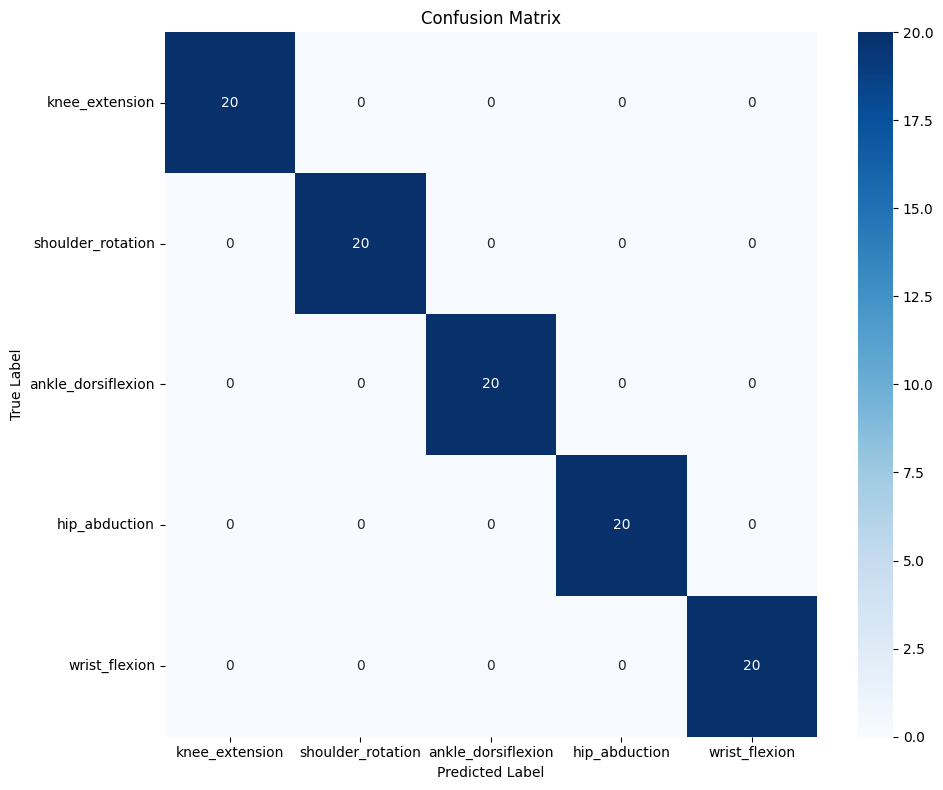


Classification Report:
                    precision    recall  f1-score   support

    knee_extension       1.00      1.00      1.00        20
 shoulder_rotation       1.00      1.00      1.00        20
ankle_dorsiflexion       1.00      1.00      1.00        20
     hip_abduction       1.00      1.00      1.00        20
     wrist_flexion       1.00      1.00      1.00        20

          accuracy                           1.00       100
         macro avg       1.00      1.00      1.00       100
      weighted avg       1.00      1.00      1.00       100

Training history not available

Saving model...
Model saved to rehabilitation_model.keras
Scaler saved to rehabilitation_model_scaler.pkl

Demonstrating movement analysis...
Analyzing test sample (true class: hip_abduction)
Performing feature engineering...
Enhanced feature shape: (1, 30, 284)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Detected exercise: shoulder_rotation (Confidence: 0.42)

Movement Analysis Feedback:
- Movement smoo

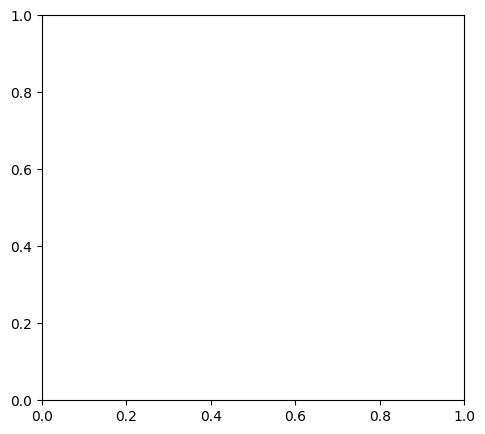

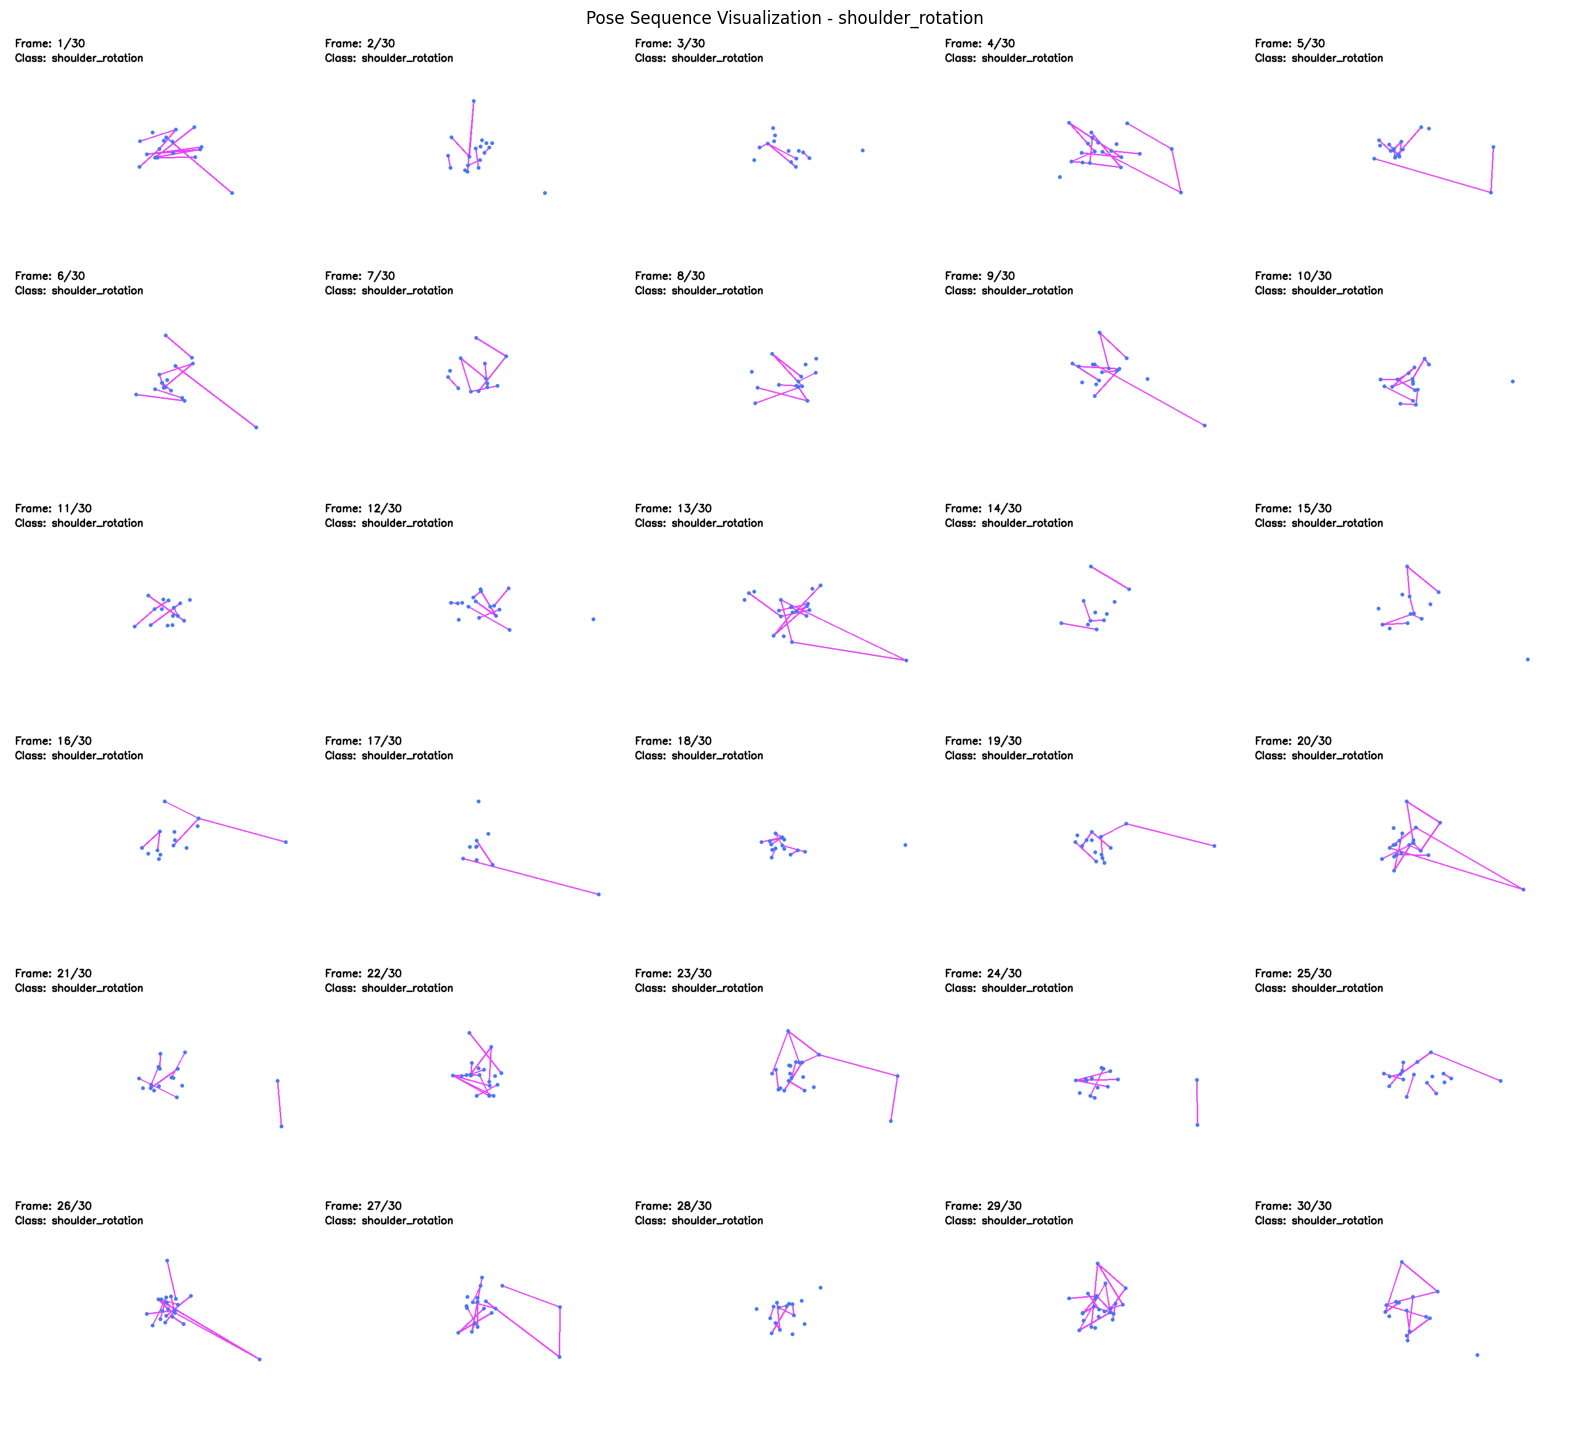


Demo completed successfully!
Performing feature engineering...
Enhanced feature shape: (100, 30, 284)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1674e-04 

Final model accuracy: 1.0000
Rehabilitation exercises classified: knee_extension, shoulder_rotation, ankle_dorsiflexion, hip_abduction, wrist_flexion


In [14]:
if __name__ == "__main__":
    # Check if TensorFlow is using GPU
    if tf.config.list_physical_devices('GPU'):
        print("GPU is available for TensorFlow!")
    else:
        print("GPU is not available. Running with CPU.")
    
    # Initialize model
    model = PoseDetectionModel(num_classes=5)
    
    # Run complete demo
    results = model.run_demo()
    
    print(f"\nFinal model accuracy: {results['accuracy']:.4f}")
    print(f"Rehabilitation exercises classified: {', '.join(results['class_names'])}")

In [15]:
# Initialize the model
pose_model = PoseDetectionModel()
pose_model.model = keras.models.load_model('/kaggle/working/rehabilitation_model.keras')

# Load an image for posture correction analysis
image_path = "/kaggle/input/yoga-poses-dataset/DATASET/TRAIN/downdog/00000128.jpg"  # Replace with your image path

# Specify the exercise type for targeted feedback
exercise_type = "knee_extension"  # Options: knee_extension, shoulder_rotation, ankle_dorsiflexion, hip_abduction, wrist_flexion

# Run the posture correction visualization
corrected_image = model.visualize_posture_correction(image_path, exercise_type)

print(f"Posture correction visualization complete for {exercise_type}")

Error in posture correction visualization: Exception encountered when calling Sequential.call().

Cannot take the length of shape with unknown rank.

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None
Posture correction visualization complete for knee_extension


Traceback (most recent call last):
  File "<ipython-input-13-6a11daf68b31>", line 1664, in visualize_posture_correction
    prediction = self.model.predict(landmarks_scaled)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Sequential.call().

Cannot take the length of shape with unknown rank.

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None
